In [167]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [168]:
# Read predictive signals updated at calendar quarter-end, as well as variables for liquidity screens
signals = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\signals_quarterly.csv")

# Format date variable
signals['date'] = pd.to_datetime(signals['date'], format='%Y%m%d')
signals['year'] = signals['date'].dt.year
signals['quarter'] = signals['date'].dt.quarter

# Variables
# permno ~ unique stock ID
# date ~ last trading day in a calendar quarter (consistent with date in msf)
# prc ~ share price (at quarter-end)
# MC ~ market capitalization at quarter-end ($Bil)
# DTV ~ average daily trading volume ($Mil) druing the past 6 months
# BM ~ book-to-market (updated using the latest quarterly accounting statements and quarter-end ME)
# R11 ~ momentum (past 12-to-2-month cumulative return)
# IA ~ investment-to-asssets (trailing 4-quarter asset growth using the latest quarterly accounting statements)
# ROE ~ return on equity (based on the most recent announced quarterly earnings report)
# beta ~ market beta (based on returns during the past 60 months)
# vol ~ daily return volatility (%, based on daily returns in the most recent month)
print(signals)

# For the signals, be clear about whether it "positively" or "negatively" predicts future returns
# positively: BM, R11, ROE
# negatively: IA
# Size/liquidity screens: MC, DTV
# Risk controls: beta, vol

        permno       date     prc          MC           DTV        BM  \
0        10001 1993-12-31   18.38    0.020053      0.009723  0.573449   
1        10001 1994-03-31   17.25    0.018820      0.008353  0.618234   
2        10001 1994-06-30    8.63    0.018908      0.005206  0.639242   
3        10001 1994-09-30    9.25    0.020452      0.004705  0.628455   
4        10001 1994-12-30    8.00    0.017792      0.002972  0.705317   
...        ...        ...     ...         ...           ...       ...   
581645   93436 2022-12-30  123.18  389.741520  19569.478909  0.093390   
581646   93436 2023-03-31  207.46  657.505882  24395.015188  0.060640   
581647   93436 2023-06-30  261.77  830.857980  29356.666587  0.053903   
581648   93436 2023-09-29  250.22  795.449380  29204.271367  0.060411   
581649   93436 2023-12-29  248.48  789.898290  29111.794688  0.064606   

             R11        IA       ROE      beta       vol  year  quarter  
0       0.253691  0.255446 -0.027836 -0.105077  2

In [169]:
# ---- 1. Basic cleaning / screens ----
signals_cs = signals.copy()

# Example screens (you can tweak)
signals_cs = signals_cs[
    (signals_cs['prc'] >= 5) &          # avoid penny stocks
    (signals_cs['MC'] > 0) &            # positive market cap
    signals_cs['BM'].notna() &
    signals_cs['beta'].notna()
]

print("Number of obs after screens:", len(signals_cs))

# ---- 2. Set up regression: BM_i = a + b * beta_i + e_i ----
y = signals_cs['BM']
X = sm.add_constant(signals_cs['beta'])

ols_pooled = sm.OLS(y, X).fit(cov_type='HC1')  # robust SEs
print(ols_pooled.summary())

Number of obs after screens: 369844
                            OLS Regression Results                            
Dep. Variable:                     BM   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2780.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:54:07   Log-Likelihood:            -2.8209e+05
No. Observations:              369844   AIC:                         5.642e+05
Df Residuals:                  369842   BIC:                         5.642e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

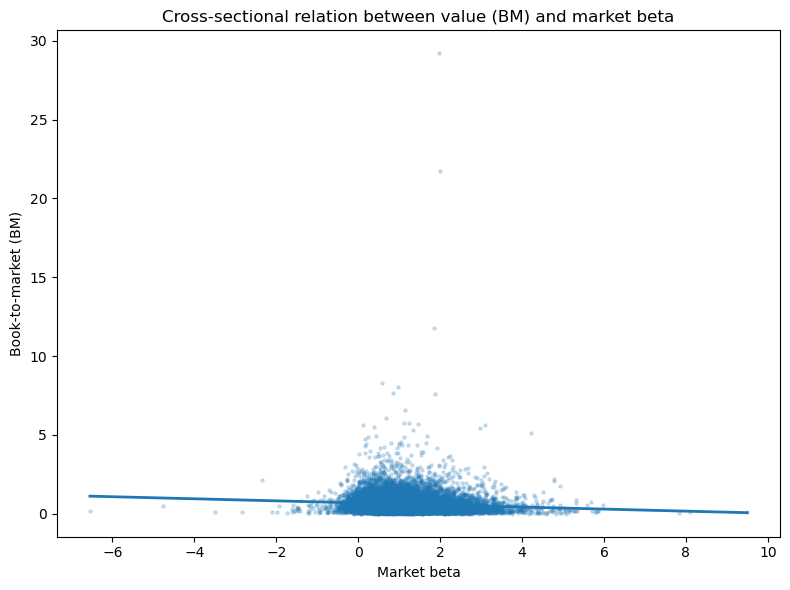

In [170]:
# Sample a subset for plotting to keep it readable (optional)
plot_sample = signals_cs.sample(n=20000, random_state=0) if len(signals_cs) > 20000 else signals_cs

beta_vals = plot_sample['beta']
bm_vals = plot_sample['BM']

# Fitted line from the pooled regression
beta_grid = np.linspace(beta_vals.min(), beta_vals.max(), 100)
bm_hat = ols_pooled.params['const'] + ols_pooled.params['beta'] * beta_grid

plt.figure(figsize=(8, 6))
plt.scatter(beta_vals, bm_vals, alpha=0.2, s=5)
plt.plot(beta_grid, bm_hat, linewidth=2)
plt.xlabel("Market beta")
plt.ylabel("Book-to-market (BM)")
plt.title("Cross-sectional relation between value (BM) and market beta")
plt.tight_layout()
plt.show()


In [171]:
# Take the same cleaned sample
signals_cs = signals[
    (signals['prc'] >= 5) &
    (signals['MC'] > 0) &
    signals['BM'].notna() &
    signals['beta'].notna()
].copy()

# Define a value subset: e.g., top 30% by BM each quarter
signals_cs['bm_rank_q'] = signals_cs.groupby('date')['BM'].rank(method='first')
signals_cs['bm_pct_q'] = signals_cs.groupby('date')['bm_rank_q'].transform(
    lambda r: r / r.max()
)

value_subset = signals_cs[signals_cs['bm_pct_q'] >= 0.7]  # top 30% BM

print("Value subset obs:", len(value_subset))

y = value_subset['BM']
X = sm.add_constant(value_subset['beta'])
ols_value = sm.OLS(y, X).fit(cov_type='HC1')
print(ols_value.summary())


Value subset obs: 111018
                            OLS Regression Results                            
Dep. Variable:                     BM   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     316.6
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           1.00e-70
Time:                        16:54:07   Log-Likelihood:            -1.0513e+05
No. Observations:              111018   AIC:                         2.103e+05
Df Residuals:                  111016   BIC:                         2.103e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1003      

In [172]:
# Start from your signals DataFrame
sig = signals.copy()

# ---- 1. Basic cleaning & investability screens ----
# Tweak these if needed to match class conventions
sig = sig[
    (sig['prc'] >= 5) &            # avoid penny stocks
    (sig['MC'] > 0) &              # positive market cap
    sig['BM'].notna() &            # need value signal
    sig['beta'].notna() &          # need beta
    sig['DTV'].notna()             # for liquidity if needed
].copy()

print("Obs after basic screens:", len(sig))

# ---- 2. Limit to a large-cap / liquid universe each quarter ----
# Example: keep top 1500 by MC per quarter
sig['mc_rank_q'] = sig.groupby('date')['MC'].rank(method='first', ascending=False)
sig = sig[sig['mc_rank_q'] <= 1500].copy()

print("Obs after top-1500 MC per quarter:", len(sig))

# ---- 3. Build a pure value score (you can extend later) ----
# For now use BM only; we can add E/P, C/P etc. later if available.

# Percentile rank of BM within each quarter (0–1, higher = more value)
sig['pBM'] = sig.groupby('date')['BM'].rank(method='first', pct=True)

# Simple value score = percentile BM (higher = more value)
sig['value_score'] = sig['pBM']

# ---- 4. Flag "value universe" (e.g., top 30% by value_score each quarter) ----
sig['value_rank_q'] = sig.groupby('date')['value_score'].rank(method='first')
sig['value_pct_q'] = sig.groupby('date')['value_rank_q'].transform(
    lambda r: r / r.max()
)

value_cutoff = 0.70  # top 30%
sig['is_value'] = (sig['value_pct_q'] >= value_cutoff).astype(int)

print("Number of quarter-ends:", sig['date'].nunique())
print("Avg stocks per quarter (post filters):", sig.groupby('date')['permno'].nunique().mean())
print("Avg value stocks per quarter:", sig[sig['is_value'] == 1].groupby('date')['permno'].nunique().mean())

sig.head()

Obs after basic screens: 369844
Obs after top-1500 MC per quarter: 181500
Number of quarter-ends: 121
Avg stocks per quarter (post filters): 1500.0
Avg value stocks per quarter: 451.0


,permno,date,prc,MC,DTV,BM,R11,IA,ROE,beta,vol,year,quarter,mc_rank_q,pBM,value_score,value_rank_q,value_pct_q,is_value
512,10026,2008-09-30,33.91,0.635745,2.393652,0.497366,-0.023038,0.103256,0.034219,1.004903,2.045332,2008,3,1408.0,0.484667,0.484667,727.0,0.484667,0
513,10026,2008-12-31,35.88,0.657393,2.338814,0.493596,-0.040201,0.084060,0.034494,0.886696,2.658729,2008,4,1141.0,0.349333,0.349333,524.0,0.349333,0
514,10026,2009-03-31,34.69,0.637429,2.526266,0.533133,0.159420,0.073944,0.012709,0.858505,2.703355,2009,1,1062.0,0.348000,0.348000,522.0,0.348000,0
515,10026,2009-06-30,35.90,0.661745,3.066504,0.497406,0.380176,0.042597,0.022008,0.784567,1.448531,2009,2,1190.0,0.404667,0.404667,607.0,0.404667,0
516,10026,2009-09-30,43.19,0.800138,2.906390,0.419251,0.299359,0.048522,0.044503,0.815050,0.712911,2009,3,1225.0,0.408000,0.408000,612.0,0.408000,0


In [173]:
# Start from the cleaned signal dataframe `sig` with is_value already defined
port_holdings = sig[sig['is_value'] == 1].copy()

# Rename quarter-end date for clarity
port_holdings = port_holdings.rename(columns={'date': 'qdate'})

# Compute value-weighted (MC-weighted) portfolio weights within each quarter
port_holdings['w_mc'] = port_holdings.groupby('qdate')['MC'].transform(
    lambda x: x / x.sum()
)

# Keep only what we need
port_holdings = port_holdings[['qdate', 'permno', 'w_mc', 'BM', 'beta']]

port_holdings.head()

,qdate,permno,w_mc,BM,beta
727,2002-09-30,10032,0.000320,1.089788,2.381220
729,2003-03-31,10032,0.000298,1.113394,2.556762
730,2003-06-30,10032,0.000307,0.798533,2.515700
768,2012-12-31,10032,0.000250,0.710416,1.538718
769,2013-03-28,10032,0.000197,0.778065,1.519930


In [174]:
# === 2.1 Read monthly returns ===
# Adjust the path and column names to match your class data
msf = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\msf_6123.csv")

msf['date'] = pd.to_datetime(msf['date'], format='%Y%m%d')
# Assume columns: permno, date, ret (decimal, e.g. 0.02 = 2%)

# Sort for merge_asof
msf = msf.sort_values('date')

# === 2.2 Attach the most recent quarter-end (qdate) to each month ===
qdates = port_holdings['qdate'].drop_duplicates().sort_values().to_frame('qdate')

msf = pd.merge_asof(
    msf,
    qdates,
    left_on='date',
    right_on='qdate',
    direction='backward'
)

# Drop months before first qdate (no portfolio yet)
msf = msf[msf['qdate'].notna()].copy()

# === 2.3 Merge in the portfolio weights ===
msf_port = msf.merge(
    port_holdings[['qdate', 'permno', 'w_mc']],
    on=['qdate', 'permno'],
    how='inner'   # only stocks in the portfolio
)

# === 2.4 Compute monthly portfolio return as weight * stock return ===
msf_port['contrib'] = msf_port['w_mc'] * msf_port['ret']

port_ret = msf_port.groupby('date')['contrib'].sum().to_frame('ret_port')
port_ret = port_ret.sort_index()

port_ret.head()


,ret_port
date,
1993-12-31,0.022464
1994-01-31,0.027651
1994-02-28,-0.038929
1994-03-31,-0.045261
1994-04-29,0.019074


In [175]:
# Read daily FF5 + UMD (the file you sampled from)
ff_daily = pd.read_csv(
    r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7032 Quant Equity Investing\Data Sessions\Data Storage\FF5.csv")

# Parse date
ff_daily['date'] = pd.to_datetime(ff_daily['Date'], format='%Y%m%d')

# Already in decimals: e.g., 0.006 = 0.6%, so DO NOT divide by 100
print(ff_daily[['date', 'mktrf', 'rf']].head())

# Create year-month key
ff_daily['year'] = ff_daily['date'].dt.year
ff_daily['month'] = ff_daily['date'].dt.month

# Helper: compound daily to monthly: (1+r_month) = Π(1+r_day)
def compound_return(x):
    return (1.0 + x).prod() - 1.0

# Group by month and compound
ff_monthly = (
    ff_daily
    .groupby(['year', 'month'])
    .agg({
        'mktrf': compound_return,
        'smb': compound_return,
        'hml': compound_return,
        'rmw': compound_return,
        'cma': compound_return,
        'umd': compound_return,
        'rf': compound_return
    })
    .reset_index()
)

# Build a month-end date for merging: use last calendar day of month
ff_monthly['date'] = pd.to_datetime(
    ff_monthly['year'].astype(str) + '-' + ff_monthly['month'].astype(str) + '-01'
) + pd.offsets.MonthEnd(0)

ff_monthly = ff_monthly.sort_values('date')

print(ff_monthly.head())
print(ff_monthly[['mktrf', 'rf']].describe())


        date   mktrf       rf
0 1964-01-02  0.0060  0.00013
1 1964-01-03  0.0017  0.00013
2 1964-01-06  0.0023  0.00013
3 1964-01-07  0.0004  0.00013
4 1964-01-08  0.0034  0.00013
   year  month     mktrf       smb       hml       rmw       cma       umd  \
0  1964      1  0.022060  0.000625  0.015183  0.001584  0.011651  0.012506   
1  1964      2  0.015485  0.002690  0.028000 -0.001023  0.008997  0.000054   
2  1964      3  0.014151  0.012231  0.033964 -0.020723  0.031017 -0.003530   
3  1964      4  0.001181 -0.015127 -0.006126 -0.014059 -0.012571 -0.009312   
4  1964      5  0.014509 -0.005719  0.018003 -0.002118  0.005039  0.023611   

         rf       date  
0  0.002864 1964-01-31  
1  0.002663 1964-02-29  
2  0.003155 1964-03-31  
3  0.002864 1964-04-30  
4  0.002603 1964-05-31  
            mktrf          rf
count  728.000000  728.000000
mean     0.005750    0.003641
std      0.044838    0.002648
min     -0.231230    0.000000
25%     -0.020403    0.001471
50%      0.009626    

In [176]:
# port_ret: DataFrame with monthly portfolio returns, index = month-end date, col 'ret_port'
port_ret = port_ret.copy()
port_ret = port_ret.sort_index()
port_ret = port_ret.reset_index().rename(columns={'index': 'date'})

# Align with monthly FF factors
df_reg = port_ret.merge(ff_monthly[['date', 'mktrf', 'rf']], on='date', how='inner').copy()

# Excess portfolio return
df_reg['excess_port'] = df_reg['ret_port'] - df_reg['rf']

# CAPM regression
Y = df_reg['excess_port']
X = sm.add_constant(df_reg['mktrf'])

capm_res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(capm_res.summary())


                            OLS Regression Results                            
Dep. Variable:            excess_port   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     275.8
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           2.17e-42
Time:                        16:54:11   Log-Likelihood:                 553.67
No. Observations:                 255   AIC:                            -1103.
Df Residuals:                     253   BIC:                            -1096.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.002     -1.441      0.1

In [177]:
# Baseline holdings: value-only, MC-weighted
# If you don't already have this, rebuild quickly:
port_holdings_mc = sig[sig['is_value'] == 1].copy()
port_holdings_mc = port_holdings_mc.rename(columns={'date': 'qdate'})
port_holdings_mc['w_mc'] = port_holdings_mc.groupby('qdate')['MC'].transform(
    lambda x: x / x.sum()
)

# Ex-ante beta each quarter: sum_i w_i * beta_i
beta_quarter_mc = (
    port_holdings_mc
    .groupby('qdate')
    .apply(lambda df: (df['w_mc'] * df['beta']).sum())
    .to_frame('beta_mc')
)

print(beta_quarter_mc.describe())


          beta_mc
count  121.000000
mean     1.002395
std      0.144676
min      0.715572
25%      0.873636
50%      1.040839
75%      1.116895
max      1.298634


C:\Users\Jonbf5\AppData\Local\Temp\ipykernel_16076\1698131945.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_mc'] * df['beta']).sum())


In [178]:
def build_beta_target_weights(df_q, target_beta=0.0):
    qdate = df_q['date'].iloc[0]
    
    # Restrict to value universe
    val = df_q[df_q['is_value'] == 1].copy()
    if val.empty:
        return pd.DataFrame(columns=['qdate', 'permno', 'w_bn'])
    
    # Baseline MC weights within value subset
    val['w_mc_val'] = val['MC'] / val['MC'].sum()
    
    # --- CHANGED PART: bottom 10% by beta as low-beta bucket ---
    beta_cut = val['beta'].quantile(0.10)  # also tested 20th, and 30th percentile
    low = val[val['beta'] <= beta_cut].copy()
    high = val[val['beta'] > beta_cut].copy()
    
    # If one side is empty, fall back to MC weights
    if low.empty or high.empty:
        val['w_bn'] = val['w_mc_val']
        out = val[['permno', 'w_bn']].copy()
        out['qdate'] = qdate
        return out
    
    # Normalize MC weights within each bucket
    low['w_mc_low'] = low['MC'] / low['MC'].sum()
    high['w_mc_high'] = high['MC'] / high['MC'].sum()
    
    # Bucket betas
    beta_low = (low['w_mc_low'] * low['beta']).sum()
    beta_high = (high['w_mc_high'] * high['beta']).sum()
    
    # Solve for mix a to hit (or get close to) target_beta
    if beta_low <= target_beta <= beta_high or beta_high <= target_beta <= beta_low:
        denom = (beta_high - beta_low)
        if abs(denom) < 1e-8:
            val['w_bn'] = val['w_mc_val']
            out = val[['permno', 'w_bn']].copy()
            out['qdate'] = qdate
            return out
        
        a = (beta_high - target_beta) / denom
        a = max(0.0, min(1.0, a))
    else:
        # target outside reachable range; choose closer bucket
        if abs(beta_low - target_beta) < abs(beta_high - target_beta):
            a = 1.0   # all low bucket
        else:
            a = 0.0   # all high bucket
    
    low['w_bn'] = a * low['w_mc_low']
    high['w_bn'] = (1 - a) * high['w_mc_high']
    
    combined = pd.concat([low, high], ignore_index=True)
    combined['w_bn'] = combined['w_bn'] / combined['w_bn'].sum()
    
    out = combined[['permno', 'w_bn']].copy()
    out['qdate'] = qdate
    return out


In [179]:
beta_target_list = []
for qdate, df_q in sig.groupby('date'):
    beta_target_list.append(build_beta_target_weights(df_q, target_beta=0.0))

port_holdings_bn = pd.concat(beta_target_list, ignore_index=True)


In [180]:
tmp_bn = port_holdings_bn.merge(
    sig[['date', 'permno', 'beta']].rename(columns={'date': 'qdate'}),
    on=['qdate', 'permno'],
    how='left'
)

beta_quarter_bn = (
    tmp_bn
    .groupby('qdate')
    .apply(lambda df: (df['w_bn'] * df['beta']).sum())
    .to_frame('beta_bn')
)

print(beta_quarter_bn.describe())
print(beta_quarter_mc.join(beta_quarter_bn, how='inner').mean())


            beta_bn
count  1.210000e+02
mean   2.338121e-01
std    1.470155e-01
min   -1.249001e-16
25%    1.377279e-01
50%    2.452113e-01
75%    3.544554e-01
max    6.300806e-01
beta_mc    1.002395
beta_bn    0.233812
dtype: float64


C:\Users\Jonbf5\AppData\Local\Temp\ipykernel_16076\3008115992.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['w_bn'] * df['beta']).sum())


In [181]:
# Ensure msf has 'date', 'permno', 'ret' and is sorted
msf_sorted = msf.sort_values('date').copy()

# Drop any old qdate column that might exist from earlier experiments
if 'qdate' in msf_sorted.columns:
    msf_sorted = msf_sorted.drop(columns=['qdate'])

# Build qdates_bn as a proper DataFrame with a 'qdate' column
qdates_bn = (
    port_holdings_bn[['qdate']]
    .drop_duplicates()
    .sort_values('qdate')
    .reset_index(drop=True)
)

print("qdates_bn columns:", qdates_bn.columns)
print(qdates_bn.head())

# Attach qdate to each month via merge_asof
msf_bn = pd.merge_asof(
    msf_sorted,
    qdates_bn,
    left_on='date',
    right_on='qdate',
    direction='backward'
)

print("msf_bn columns after merge_asof:", msf_bn.columns)

# Keep only months after the first qdate
msf_bn = msf_bn[msf_bn['qdate'].notna()].copy()

# Merge in beta-target weights
msf_port_bn = msf_bn.merge(
    port_holdings_bn[['qdate', 'permno', 'w_bn']],
    on=['qdate', 'permno'],
    how='inner'
)

msf_port_bn['contrib'] = msf_port_bn['w_bn'] * msf_port_bn['ret']

port_ret_bn = (
    msf_port_bn
    .groupby('date')['contrib']
    .sum()
    .to_frame('ret_port_bn')
    .sort_index()
)

print(port_ret_bn.head())


qdates_bn columns: Index(['qdate'], dtype='object')
       qdate
0 1993-12-31
1 1994-03-31
2 1994-06-30
3 1994-09-30
4 1994-12-30
msf_bn columns after merge_asof: Index(['permno', 'date', 'ticker', 'exchcd', 'ret', 'prc', 'shrout', 'qdate'], dtype='object')
            ret_port_bn
date                   
1993-12-31     0.016452
1994-01-31    -0.005387
1994-02-28    -0.032931
1994-03-31    -0.025985
1994-04-29     0.023302


In [182]:
port_ret_bn_reset = port_ret_bn.reset_index().rename(columns={'index': 'date'})

df_reg_bn = port_ret_bn_reset.merge(
    ff_monthly[['date', 'mktrf', 'rf']],
    on='date',
    how='inner'
).copy()

df_reg_bn['excess_port_bn'] = df_reg_bn['ret_port_bn'] - df_reg_bn['rf']

Y_bn = df_reg_bn['excess_port_bn']
X_bn = sm.add_constant(df_reg_bn['mktrf'])

capm_res_bn = sm.OLS(Y_bn, X_bn).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(capm_res_bn.summary())


                            OLS Regression Results                            
Dep. Variable:         excess_port_bn   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     48.18
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           3.26e-11
Time:                        16:54:12   Log-Likelihood:                 489.40
No. Observations:                 255   AIC:                            -974.8
Df Residuals:                     253   BIC:                            -967.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.339      0.7

In [183]:
# Final fund: low-beta value
fund = port_ret_bn.copy()      # DataFrame with index=date, col='ret_port_bn'
fund = fund.sort_index()
fund.rename(columns={'ret_port_bn': 'ret_fund'}, inplace=True)
fund.head()



,ret_fund
date,
1993-12-31,0.016452
1994-01-31,-0.005387
1994-02-28,-0.032931
1994-03-31,-0.025985
1994-04-29,0.023302


In [184]:
# Merge with RF to get excess returns
df_perf = fund.reset_index().merge(
    ff_monthly[['date', 'rf']],
    on='date',
    how='inner'
)
df_perf.set_index('date', inplace=True)

df_perf['excess'] = df_perf['ret_fund'] - df_perf['rf']

def summarize_returns(df, ret_col='ret_fund', excess_col='excess', name='Low-beta Value'):
    r = df[ret_col]
    rx = df[excess_col]

    # Monthly stats
    mean_m   = r.mean()
    vol_m    = r.std()
    sharpe_m = rx.mean() / rx.std()

    # Annualized (simple)
    mean_ann = (1 + mean_m)**12 - 1
    vol_ann  = vol_m * np.sqrt(12)
    sharpe_ann = ( (1 + rx.mean())**12 - 1 ) / (vol_ann)  # rough

    # Max drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1)
    max_dd = dd.min()

    summary = pd.Series({
        'Name': name,
        'Mean monthly': mean_m,
        'Vol monthly': vol_m,
        'Sharpe monthly': sharpe_m,
        'Mean annual': mean_ann,
        'Vol annual': vol_ann,
        'Sharpe annual (rough)': sharpe_ann,
        'Max drawdown': max_dd
    })
    return summary

summary_fund = summarize_returns(df_perf, name='Low-beta Value')
summary_fund

Name                     Low-beta Value
Mean monthly                   0.006174
Vol monthly                    0.040983
Sharpe monthly                 0.103118
Mean annual                    0.076662
Vol annual                     0.141971
Sharpe annual (rough)          0.366799
Max drawdown                  -0.295417
dtype: object

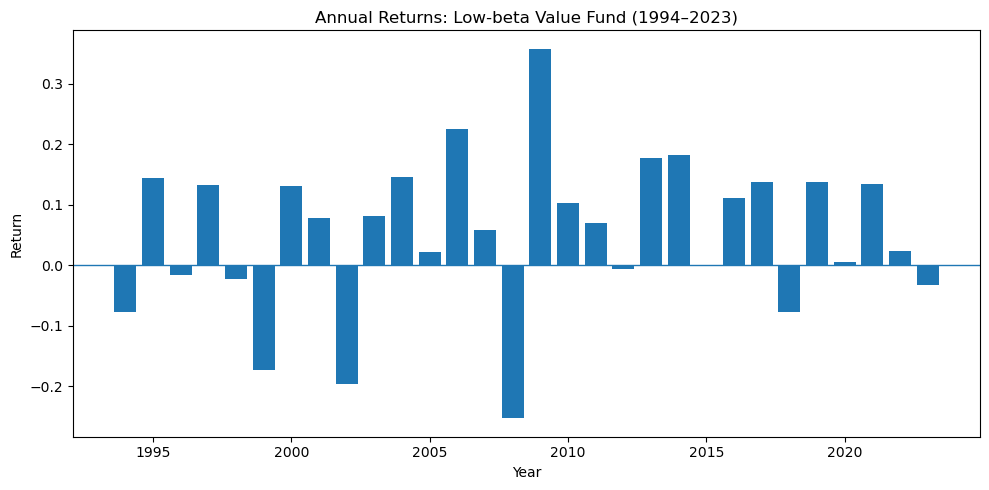

date
1994   -0.077362
1995    0.145242
1996   -0.015487
1997    0.132695
1998   -0.023278
1999   -0.173198
2000    0.131560
2001    0.078084
2002   -0.196763
2003    0.082008
2004    0.145881
2005    0.021897
2006    0.225975
2007    0.057794
2008   -0.252648
2009    0.358009
2010    0.103636
2011    0.069874
2012   -0.006724
2013    0.177215
2014    0.182557
2015   -0.000291
2016    0.110853
2017    0.137361
2018   -0.076942
2019    0.137293
2020    0.005265
2021    0.135183
2022    0.023471
2023   -0.032408
Name: ret_fund, dtype: float64


In [185]:
# Annual returns for final fund
annual = (1 + df_perf['ret_fund']).groupby(df_perf.index.year).prod() - 1

# Restrict to 1994–2023 just in case
annual = annual.loc[1994:2023]

plt.figure(figsize=(10,5))
plt.bar(annual.index, annual.values)
plt.axhline(0, linewidth=1)
plt.title("Annual Returns: Low-beta Value Fund (1994–2023)")
plt.xlabel("Year")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

print(annual)


Summary metrics (in % where applicable):
                  Low-beta value  Baseline value    S&P 500
Mean monthly (%)        0.613395        0.717736   0.957126
Vol monthly (%)         4.105928        5.470853   4.464438
Sharpe (monthly)        0.101970        0.095694   0.171049
Mean annual (%)         7.614214        8.961088  12.109843
Vol annual (%)         14.223351       18.951591  15.465266
Beta (vs MktRF)         0.448621        1.027276   0.958248
Max drawdown (%)      -29.541745      -48.075351 -37.865574


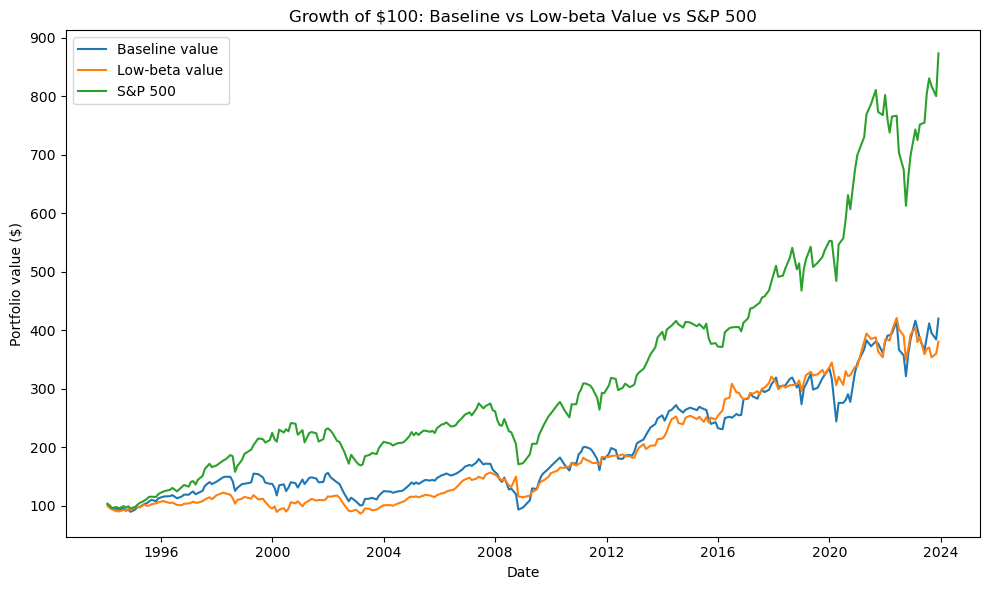

In [ ]:
# ========= 1. Build combined monthly DataFrame =========
# Assumes you already have:
# - port_ret with index=date, col 'ret_port'     (baseline value)
# - port_ret_bn with index=date, col 'ret_port_bn' (low-beta value)
# - sp with 'date', 'ret_sp'                    (S&P 500 total return, decimal)
# - ff_monthly with 'date', 'mktrf', 'rf'       (monthly market & RF, decimal)

combined = (
    port_ret.reset_index().rename(columns={'ret_port': 'baseline'})
    .merge(
        port_ret_bn.reset_index().rename(columns={'ret_port_bn': 'low_beta'}),
        on='date',
        how='inner'
    )
    .merge(
        sp[['date', 'ret_sp']].rename(columns={'ret_sp': 'sp500'}),
        on='date',
        how='inner'
    )
    .merge(
        ff_monthly[['date', 'mktrf', 'rf']],
        on='date',
        how='inner'
    )
    .set_index('date')
    .sort_index()
)

# ========= 2. Metric function (returns in PERCENT) =========

def compute_metrics(ret, rf, mktrf):
    """
    ret, rf, mktrf: monthly returns in decimal form (Series aligned on same dates).
    Returns metrics with return/vol/dd in PERCENT, beta & Sharpe unitless.
    """
    df = pd.concat([ret, rf, mktrf], axis=1).dropna()
    r = df.iloc[:, 0]
    rf_s = df.iloc[:, 1]
    mktrf_s = df.iloc[:, 2]

    ex = r - rf_s

    mean_m   = r.mean()
    vol_m    = r.std()
    sharpe_m = ex.mean() / ex.std()

    mean_ann = (1 + mean_m)**12 - 1
    vol_ann  = vol_m * np.sqrt(12)

    # Beta vs market excess
    if mktrf_s.var() != 0:
        beta = np.cov(ex, mktrf_s)[0, 1] / np.var(mktrf_s)
    else:
        beta = np.nan

    # Max drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min()

    return {
        'Mean monthly (%)':   mean_m * 100,
        'Vol monthly (%)':    vol_m * 100,
        'Sharpe (monthly)':   sharpe_m,
        'Mean annual (%)':    mean_ann * 100,
        'Vol annual (%)':     vol_ann * 100,
        'Beta (vs MktRF)':    beta,
        'Max drawdown (%)':   max_dd * 100,
    }

metrics = {}
metrics['Low-beta value'] = compute_metrics(
    combined['low_beta'],
    combined['rf'],
    combined['mktrf']
)
metrics['Baseline value'] = compute_metrics(
    combined['baseline'],
    combined['rf'],
    combined['mktrf']
)
metrics['S&P 500'] = compute_metrics(
    combined['sp500'],
    combined['rf'],
    combined['mktrf']
)

metrics_df = pd.DataFrame(metrics)
print("Summary metrics (in % where applicable):")
print(metrics_df)

# ========= 3. "Map" tracking value over time (equity curves) =========

equity = (1 + combined[['baseline', 'low_beta', 'sp500']]).cumprod()
equity_100 = equity * 100  # start at 100 instead of 1

plt.figure(figsize=(10, 6))
plt.plot(equity_100.index, equity_100['baseline'], label='Baseline value')
plt.plot(equity_100.index, equity_100['low_beta'], label='Low-beta value')
plt.plot(equity_100.index, equity_100['sp500'], label='S&P 500')
plt.title("Growth of $100: Baseline vs Low-beta Value vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.tight_layout()
plt.show()


In [189]:
df_ff = df_perf.merge(
    ff_monthly[['date','mktrf','smb','hml']],
    left_index=True,
    right_on='date',
    how='inner'
).set_index('date')

df_ff['excess'] = df_ff['ret_fund'] - df_ff['rf']

Y = df_ff['excess']
X = sm.add_constant(df_ff[['mktrf','smb','hml']])

ff3_res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})
print(ff3_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     51.23
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           7.27e-26
Time:                        17:00:47   Log-Likelihood:                 519.20
No. Observations:                 255   AIC:                            -1030.
Df Residuals:                     251   BIC:                            -1016.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.162      0.8

In [193]:
# ========= 1. Build annual return series for fund and S&P =========

# Annual total returns: (1+r_month)^12ish → (1+r_year)
annual_fund = (1 + combined['low_beta']).groupby(combined.index.year).prod() - 1
annual_sp   = (1 + combined['sp500']).groupby(combined.index.year).prod() - 1

# Restrict to overlapping years just in case
common_years = annual_fund.index.intersection(annual_sp.index)
annual_fund = annual_fund.loc[common_years]
annual_sp   = annual_sp.loc[common_years]

# ========= 2. Helper: CAGR over the last N years =========

def cagr_last_n_years(annual_series, n):
    """
    Computes the compounded average annual return over the last n years
    of an annual return series.
    """
    if len(annual_series) < n:
        return np.nan  # not enough history

    end_year = annual_series.index.max()
    start_year = end_year - n + 1
    sub = annual_series.loc[start_year:end_year]

    total_return = (1 + sub).prod() - 1
    # Compounded average annual rate over that window
    cagr = (1 + total_return)**(1 / len(sub)) - 1
    return cagr

# ========= 3. Compute CAGRs for 1, 3, 5, 10, 30 years =========

horizons = [1, 3, 5, 10, 30]
rows = {}
for n in horizons:
    rows[f"Last {n} years"] = {
        "Fund CAGR (%)": cagr_last_n_years(annual_fund, n) * 100,
        "S&P CAGR (%)":  cagr_last_n_years(annual_sp, n) * 100,
    }

benchmarks_df = pd.DataFrame(rows).T
print("Compounded average annual return over trailing windows (in %):")
print(benchmarks_df)

Compounded average annual return over trailing windows (in %):
               Fund CAGR (%)  S&P CAGR (%)
Last 1 years       -3.240766     24.889434
Last 3 years        3.978759      7.684338
Last 5 years        5.147110     13.295605
Last 10 years       5.887972      8.191985
Last 30 years       4.554221      7.489537
